NO2: baseline=395898, stat=379
bl_df shape: (188592, 47)
stat_df shape: (379, 47)
sens_coef: [0.06756033]
Baseline: CatBoost R2 = 0.698


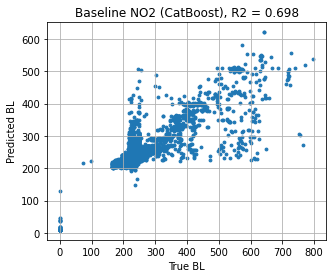

Sens: Linear R2 = 0.514


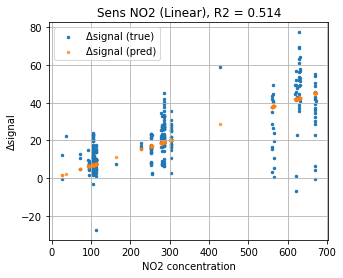

In [12]:
import pandas as pd
import numpy as np
from glob import glob
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os

# === 1. Загрузка и признаки ===
def load_lab_data(data_dir, gases, t_cols, rh_cols):
    files = glob(os.path.join(data_dir, '*_stat.csv'))
    dfs = [pd.read_csv(file) for file in files]
    df = pd.concat(dfs, ignore_index=True).sort_values('date')
    for gas in gases:
        if t_cols.get(gas) and t_cols[gas] in df.columns:
            df[f"{t_cols[gas]}_grad"] = df[t_cols[gas]].diff()
            df[f"{t_cols[gas]}_2"] = df[t_cols[gas]] ** 2
        if rh_cols.get(gas) and rh_cols[gas] in df.columns:
            df[f"{rh_cols[gas]}_grad"] = df[rh_cols[gas]].diff()
            df[f"{rh_cols[gas]}_2"] = df[rh_cols[gas]] ** 2
        if t_cols.get(gas) and rh_cols.get(gas) and t_cols[gas] in df.columns and rh_cols[gas] in df.columns:
            df[f"{t_cols[gas]}_x_{rh_cols[gas]}"] = df[t_cols[gas]] * df[rh_cols[gas]]
    return df

# === 2. Маски ===
def add_bl_stat_masks(df, gas, t_col, rh_col, signal_col=None, std_thr=10, window=5, baseline_eps=0.01, verbose=True):
    if signal_col is None:
        signal_col = f"{gas}op1"
    bl_mask = (df[gas].fillna(0) < baseline_eps) & df[signal_col].notna()
    rolling_std = df[signal_col].rolling(window, center=True).std()
    stat_mask = (rolling_std < std_thr).fillna(False) & (~bl_mask)
    if verbose:
        print(f"{gas}: baseline={bl_mask.sum()}, stat={stat_mask.sum()}")
    df[f"{signal_col}_bl"] = bl_mask
    df[f"{signal_col}_stat"] = stat_mask
    return df

# === 3. Safe dropna ===
def safe_dropna(df, cols, mask):
    ok = mask & df[cols].notna().all(axis=1)
    return df.loc[ok].copy()

# === 4. Pipeline ===
gases = ['NO2']
t_cols = {'NO2': 'NO2t'}
rh_cols = {'NO2': 'MH'}

df = load_lab_data('data_example/lab_data', gases, t_cols, rh_cols)
df = add_bl_stat_masks(df, 'NO2', t_cols['NO2'], rh_cols['NO2'], std_thr=10, window=5)

bl_col = 'NO2op1_bl'
stat_col = 'NO2op1_stat'

# Признаки как в твоём ML-коде
features_bl = [
    t_cols['NO2'], rh_cols['NO2'],
    f"{t_cols['NO2']}_grad", f"{rh_cols['NO2']}_grad",
    f"{t_cols['NO2']}_2", f"{rh_cols['NO2']}_2",
    f"{t_cols['NO2']}_x_{rh_cols['NO2']}"
]
features_bl = [f for f in features_bl if f in df.columns]
features_stat = features_bl + ['NO2']

bl_df = safe_dropna(df, features_bl + ['NO2op1'], df[bl_col].fillna(False))
stat_df = safe_dropna(df, features_bl + ['NO2op1', 'NO2'], df[stat_col].fillna(False))

print(f'bl_df shape: {bl_df.shape}')
print(f'stat_df shape: {stat_df.shape}')
if bl_df.empty or stat_df.empty:
    raise Exception("Нет данных для обучения! Проверь параметры и признаки.")

# === 5. Baseline: CatBoost ===
bl_model = CatBoostRegressor(verbose=0, random_seed=42)
bl_model.fit(bl_df[features_bl], bl_df['NO2op1'])
y_bl_pred = bl_model.predict(stat_df[features_bl])
delta_signal = stat_df['NO2op1'] - y_bl_pred

# === 6. Sens: Linear Regression ===
sens_features = ['NO2']
sens_model = LinearRegression(fit_intercept=False).fit(stat_df[sens_features], delta_signal)
print('sens_coef:', sens_model.coef_)

# === 7. Валидация и графики ===
y_bl_val = bl_df['NO2op1']
y_bl_pred_val = bl_model.predict(bl_df[features_bl])
r2_bl = r2_score(y_bl_val, y_bl_pred_val)
print(f"Baseline: CatBoost R2 = {r2_bl:.3f}")
plt.figure(figsize=(5, 4))
plt.scatter(y_bl_val, y_bl_pred_val, s=8)
plt.xlabel("True BL")
plt.ylabel("Predicted BL")
plt.title(f"Baseline NO2 (CatBoost), R2 = {r2_bl:.3f}")
plt.grid()
plt.show()

y_signal = stat_df['NO2op1']
delta_signal_val = y_signal - bl_model.predict(stat_df[features_bl])
sens_pred = sens_model.predict(stat_df[sens_features])
r2_sens = r2_score(delta_signal_val, sens_pred)
print(f"Sens: Linear R2 = {r2_sens:.3f}")
plt.figure(figsize=(5, 4))
plt.scatter(stat_df[sens_features].values[:,0], delta_signal_val, label="Δsignal (true)", s=6)
plt.scatter(stat_df[sens_features].values[:,0], sens_pred, label="Δsignal (pred)", s=6, alpha=0.7)
plt.xlabel("NO2 concentration")
plt.ylabel("Δsignal")
plt.title(f"Sens NO2 (Linear), R2 = {r2_sens:.3f}")
plt.legend()
plt.grid()
plt.show()


In [11]:
for thr in [1, 3, 5, 10, 15, 20]:
    df = add_bl_stat_masks(df, 'NO2', t_cols['NO2'], rh_cols['NO2'], std_thr=thr, window=5)
    print(f"std_thr={thr}: stat_col True:", df['NO2op1_stat'].sum())


NO2: baseline=395898, stat=2
std_thr=1: stat_col True: 2
NO2: baseline=395898, stat=25
std_thr=3: stat_col True: 25
NO2: baseline=395898, stat=80
std_thr=5: stat_col True: 80
NO2: baseline=395898, stat=379
std_thr=10: stat_col True: 379
NO2: baseline=395898, stat=546
std_thr=15: stat_col True: 546
NO2: baseline=395898, stat=617
std_thr=20: stat_col True: 617
